In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

Using plaidml.keras.backend backend.


In [3]:
from tensorflow import keras
from keras.preprocessing.image import load_img

In [4]:
trainpath='/Users/Matthias/Downloads/dogs-vs-cats/train/'

In [5]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
filenames = os.listdir(trainpath)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [8]:
df.tail()

,filename,category
24995,dog.8008.jpg,1
24996,dog.1992.jpg,1
24997,dog.12412.jpg,1
24998,cat.2701.jpg,0
24999,cat.10148.jpg,0


<AxesSubplot:>

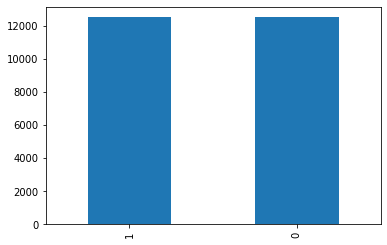

In [9]:
df['category'].value_counts().plot.bar()

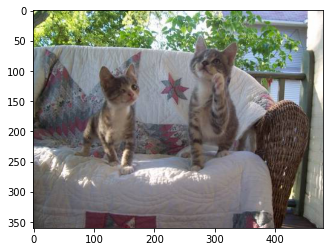

In [10]:
sample = random.choice(filenames)
image = load_img(trainpath+sample)
plt.imshow(image)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

INFO:plaidml:Opening device "metal_intel(r)_iris(tm)_graphics_6100.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_po

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
earlystop = EarlyStopping(patience=10)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

In [16]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

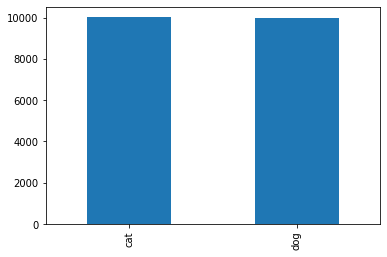

In [18]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

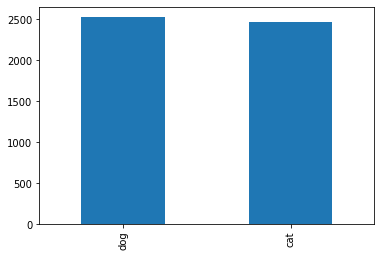

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    trainpath, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    trainpath, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    trainpath, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


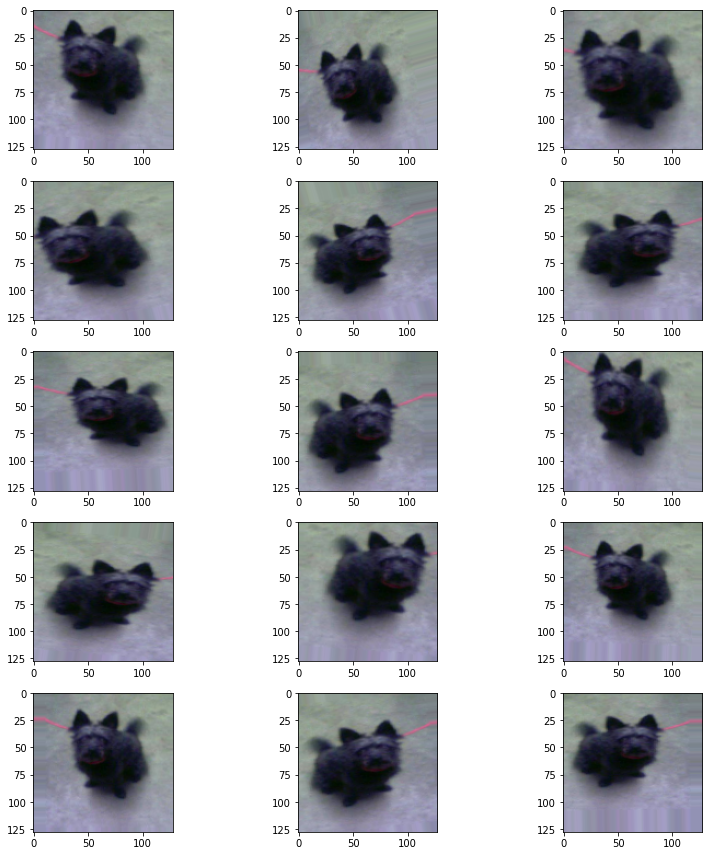

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [25]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
INFO:plaidml:Analyzing Ops: 340 of 652 operations complete
1333/1333 [==============================] - 1637s 1s/step - loss: 0.8328 - acc: 0.5541 - val_loss: 0.6775 - val_acc: 0.5904
Epoch 2/50
1333/1333 [==============================] - 1549s 1s/step - loss: 0.7054 - acc: 0.5666 - val_loss: 0.7084 - val_acc: 0.5563
Epoch 3/50
1333/1333 [==============================] - 1537s 1s/step - loss: 0.7006 - acc: 0.5740 - val_loss: 0.6668 - val_acc: 0.6014
Epoch 4/50
1333/1333 [==============================] - 1537s 1s/step - loss: 0.6793 - acc: 0.6008 - val_loss: 0.6588 - val_acc: 0.6299
Epoch 5/50
1333/1333 [==============================] - 1535s 1s/step - loss: 0.6847 - acc: 0.5928 - val_loss: 0.8900 - val_acc: 0.5266
Epoch 6/50
1333/1333 [==============================] - 1539s 1s/step - loss: 0.6832 - acc: 0.5919 - val_loss: 0.6649 - val_acc: 0.6056

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
1333/1333 [======================

KeyboardInterrupt: 